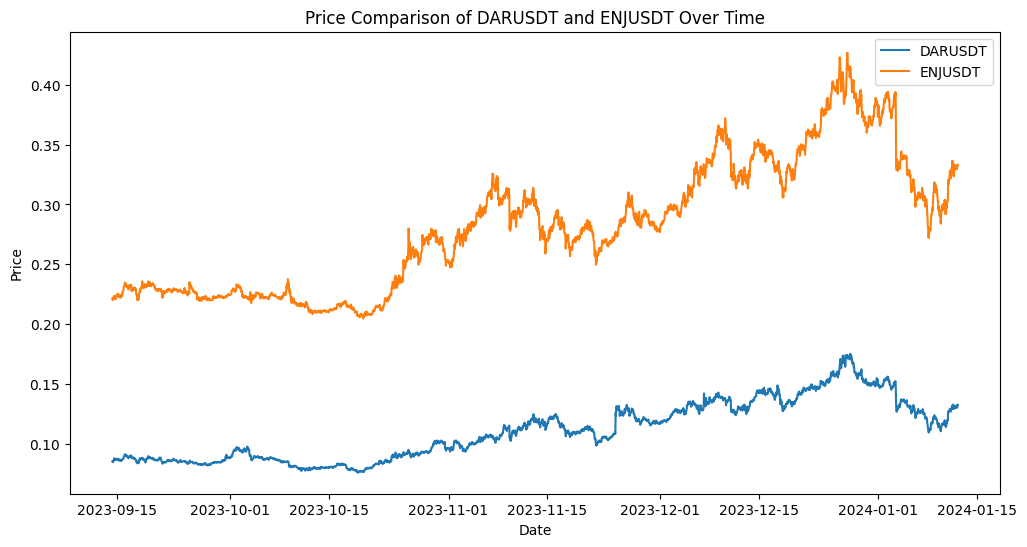

HEDGE RATIO: 2.1516107878467072
P Value:  0.023177181032223732
Pair is Cointegrated


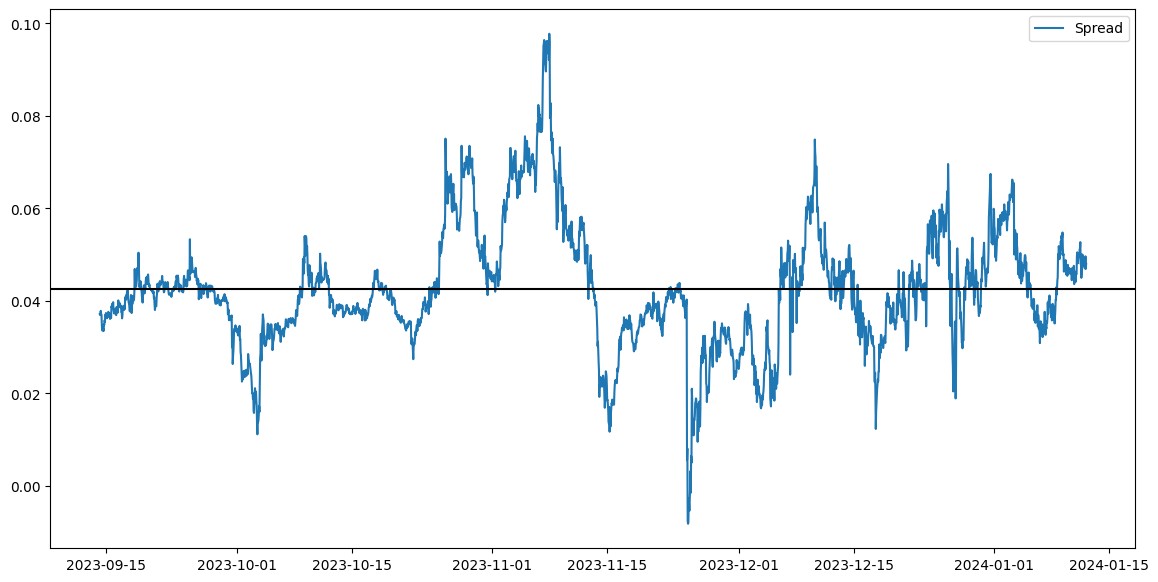

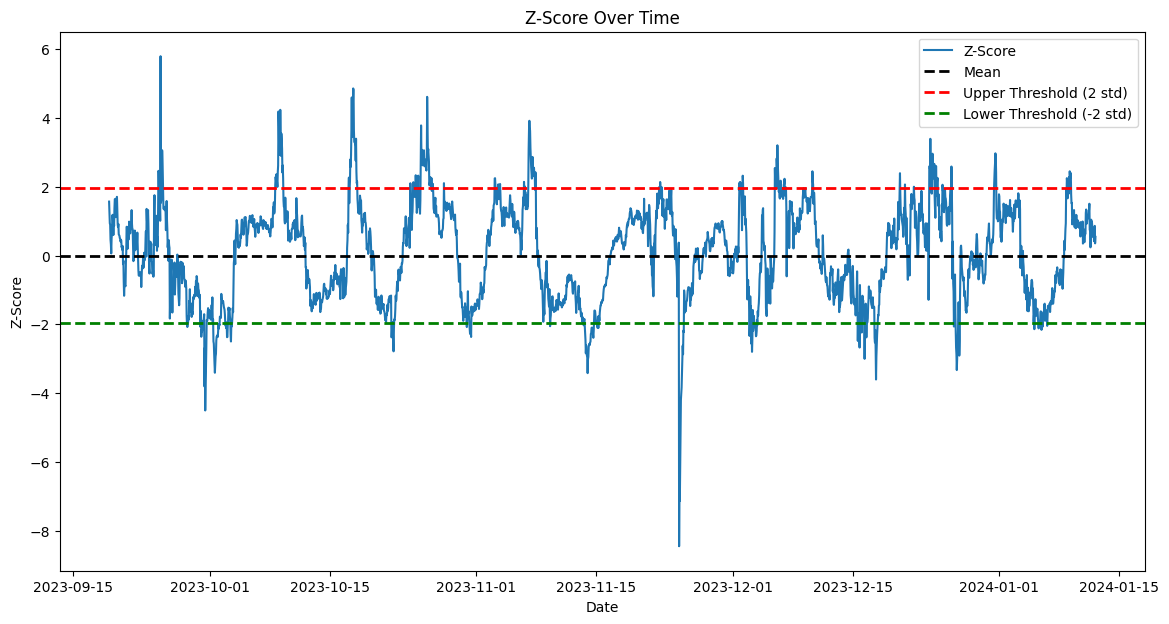

ADF Statistic: -3.6464139758485152
p-value: 0.004933233817947575
Critical Values:
	1%: -3.4326441441956144
	5%: -2.862553595853849
	10%: -2.567309566974286
Null hypothesis that the spread is not stationary cannot be rejected 
Mean z-score: 0.07507933405870726
Standard deviation of z-score: 1.4003826426666162
Entry Threshold: 1.4754619767253234
Exit Threshold: 0.07507933405870726


In [7]:
import logging
import pandas as pd
import ccxt
from datetime import datetime
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
import matplotlib.pyplot as plt


def fetch_prices(binance, symbol_one, symbol_two, look_back_days): 
    # Prepare empty dataframe for results
    df_final = pd.DataFrame()
    
    # Calculate the end timestamp for the data fetching
    end_timestamp = binance.milliseconds()
    since_timestamp = end_timestamp - look_back_days * 24 * 60 * 60 * 1000 
    
    while since_timestamp < end_timestamp:
        try:
            # Fetch OHLCV data
            
            ohlcv_one = binance.fetch_ohlcv(symbol_one, '1h', since=since_timestamp)
            ohlcv_two = binance.fetch_ohlcv(symbol_two, '1h', since=since_timestamp)
            
            # Create temporary dataframes to hold fetched data
            df_one_temp = pd.DataFrame(ohlcv_one, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
            df_two_temp = pd.DataFrame(ohlcv_two, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
            
            # Merge dataframes
            df_temp = pd.merge(df_one_temp[['timestamp', 'close']], df_two_temp[['timestamp', 'close']], on='timestamp', how='inner')
            df_temp.columns = ['timestamp', symbol_one, symbol_two]
            
            # Concatenate with the final dataframe
            df_final = pd.concat([df_final, df_temp])
            
            # Update the since_timestamp to the last timestamp fetched
            since_timestamp = df_final['timestamp'].max() + (60 * 60 * 1000)  # Add one hour

        except Exception as e:
            logging.error(f"Error in fetching prices: {e}")
            break
    
    # Remove duplicates and sort the dataframe
    df_final.drop_duplicates(subset='timestamp', keep='first', inplace=True)
    df_final.sort_values(by='timestamp', inplace=True)
    
    return df_final


def check_cointegration(prices, symbol_one, symbol_two, hedge_lookback, zscore_window):

    # ========================== Visualize Prices  ==============================

    # Convert 'timestamp' to datetime
    prices['timestamp'] = pd.to_datetime(prices['timestamp'], unit='ms')

    # Set 'timestamp' as the index
    prices.set_index('timestamp', inplace=True)

    # Ensure there are no duplicates
    prices.drop_duplicates(inplace=True)

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(prices.index, prices[symbol_one], label=symbol_one)
    plt.plot(prices.index, prices[symbol_two], label=symbol_two)

    # Adding labels and title
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title(f'Price Comparison of {symbol_one} and {symbol_two} Over Time')
    plt.legend()

    # Display the plot
    plt.show()

    recent_prices = prices.tail(hedge_lookback)

    X_with_const = sm.add_constant(recent_prices[symbol_one])

    # Perform regression to find hedge ratio using the recent data
    model = sm.OLS(recent_prices[symbol_two], X_with_const).fit()
    hedge_ratio = model.params[symbol_one]

    print(f"HEDGE RATIO: {hedge_ratio}")
    
    prices['calculated_spread'] = prices[symbol_two] - \
            hedge_ratio * prices[symbol_one]

    # Calculate the rolling mean, standard deviation, and z-score
    prices['rolling_mean_spread'] = prices['calculated_spread'].rolling(
        window=zscore_window).mean()
    prices['rolling_std_spread'] = prices['calculated_spread'].rolling(
        window=zscore_window).std()
    prices['z_score'] = (prices['calculated_spread'] -
                        prices['rolling_mean_spread']) / prices['rolling_std_spread']

    # ========================== Cointegration Check with Engle-Granger  ==============================

    x = prices[symbol_one]
    y = prices[symbol_two]

    if len(x) != len(y):
        print(f"Mismatch for Price Lengths")

    result = coint(x, y)
    score = result[0]
    pvalue = result[1]

    print("P Value: ", pvalue)

    if pvalue < 0.05:
        print("Pair is Cointegrated")

    else:
        print("Fails Engle Granger")
        return False
    
    # ========================== Stationary Check with Augmented Dickey Fuller ==============================
    adf_result = adfuller(prices['calculated_spread'])

    # Plot the z_score
    plt.figure(figsize=(14, 7))
    plt.plot(prices.index, prices['calculated_spread'], label='Calculated Spread')
    plt.axhline(prices['calculated_spread'].mean(), color='black')
    plt.legend(['Spread']);

    # Plot the z_score
    plt.figure(figsize=(14, 7))
    plt.plot(prices.index, prices['z_score'], label='Z-Score')
    plt.axhline(0, color='black', linestyle='--', linewidth=2, label='Mean')
    plt.axhline(1.96, color='red', linestyle='--', linewidth=2, label='Upper Threshold (2 std)')
    plt.axhline(-1.96, color='green', linestyle='--', linewidth=2, label='Lower Threshold (-2 std)')
    plt.title('Z-Score Over Time')
    plt.xlabel('Date')
    plt.ylabel('Z-Score')
    plt.legend(loc='best')
    plt.show()

    prices.to_csv("coint.csv", index=True)
    
    
    print(f"ADF Statistic: {adf_result[0]}")
    print(f"p-value: {adf_result[1]}")
    print('Critical Values:')
    for key, value in adf_result[4].items():
        print(f'\t{key}: {value}')
    
    if adf_result[1] < 0.05:
        print("Null hypothesis that the spread is not stationary cannot be rejected ")
        return True
    else:
        print("The spread is not cointegrated.")
        return False
    
    
symbol_one = "DARUSDT"
symbol_two =  "ENJUSDT"


# Set up exchange connection
binance = ccxt.binance()

# Fetch prices
prices = fetch_prices(binance, symbol_one, symbol_two, 120)

# Convert timestamps to datetime format and set as index
prices['time'] = pd.to_datetime(prices['timestamp'], unit='ms')
prices.set_index('time', inplace=True)


# Check if the series are cointegrated
cointegrated = check_cointegration(prices, symbol_one, symbol_two, hedge_lookback = 2880, zscore_window = 120)

# If cointegrated, we can move on to determine suitable z-score thresholds
# These would typically be determined based on historical data and the desired frequency of trading signals
if cointegrated:
    # Analyze the historical distribution of the z-score
    mean_z_score = prices['z_score'].mean()
    std_z_score = prices['z_score'].std()
    
    # Example thresholds for entry and exit
    entry_threshold = mean_z_score + std_z_score
    exit_threshold = mean_z_score
    
    print(f"Mean z-score: {mean_z_score}")
    print(f"Standard deviation of z-score: {std_z_score}")
    print(f"Entry Threshold: {entry_threshold}")
    print(f"Exit Threshold: {exit_threshold}")



